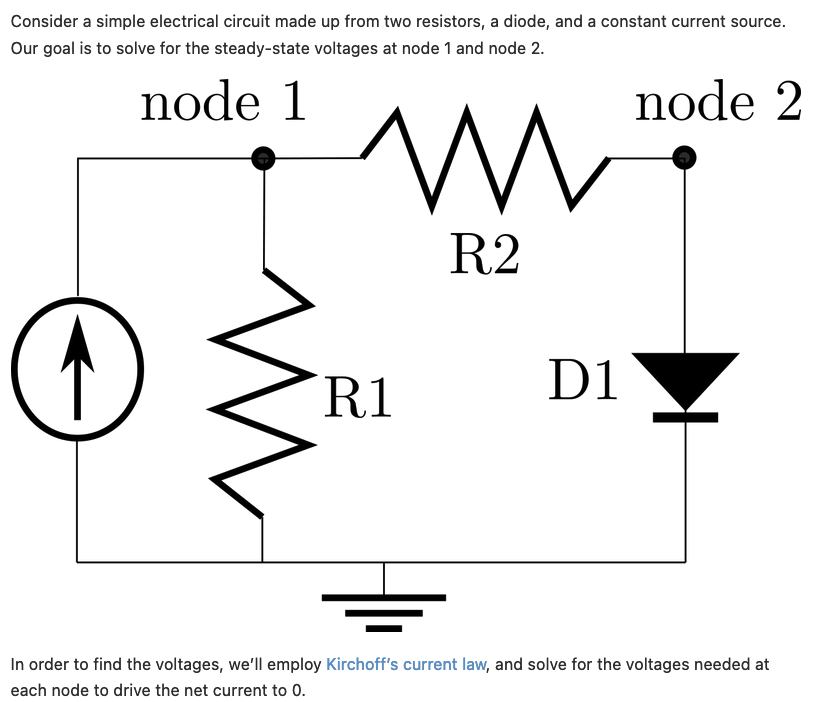

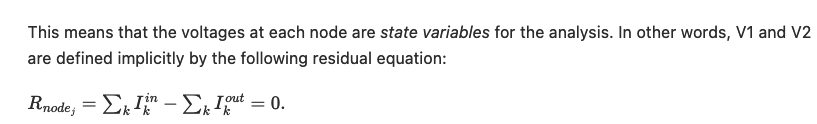

In [39]:
import openmdao.api as om
import numpy as np

class Resistor(om.ExplicitComponent):
    """
    Calculates the current across a resistor using Ohm's law.

    This component takes in two voltage inputs, 'V_in' and 'V_out', and calculates the current 'I' based on the voltage difference, and the value of the resistor 'R'. 
    
    The calculation is done using the formula I = (V_in - V_out) / R.

    Attributes (This means defined within the class, but then they are Public and are accessible outside class as well. Private has __R)
    ----------
    R : float
        The value of the resistor in ohms.

    Inputs
    ------
    V_in : float
        The input voltage in volts.
    V_out : float
        The output voltage in volts.

    Outputs
    -------
    I : float
        The current in amperes.
    """
    
    def initialize(self):
        self.options.declare('R', default=1.0, desc='Resistor')
        
    def setup(self):
        self.add_input('V_in', units='V')
        self.add_input('V_out', units='V')
        self.add_output('I', units='A')
        
    def setup_partials(self):
        self.declare_partials('I', 'V_in', method='fd')
        self.declare_partials('I', 'V_out', method='fd')
        
    def compute(self, inputs, outputs):
        R = self.options['R']
        deltaV = inputs['V_in']-inputs['V_out']
        outputs['I'] = deltaV/R

class Diode(om.ExplicitComponent):
    """
    Calculates the current across a diode using Shockley diode equation.
    -------------------------------------------------------------------

    This component takes in two voltage inputs, 'V_in' and 'V_out', and calculates the current 'I' based on the voltage difference, saturation current 'Is', and thermal voltage 'Vt'. 
    
    The calculation is done using the formula I = Is * [exp((V_in - V_out)/Vt) - 1].

    Attributes
    ----------
    Is : float
        Saturation current, in Amps.
    Vt : float
        Thermal voltage, in Volts.

    Inputs
    ------
    V_in : float
        The input voltage in volts.
    V_out : float
        The output voltage in volts.

    Outputs
    -------
    I : float
        The current in amperes.
    """
    
    def initialize(self):
        self.options.declare('Is', default=1e-15, desc='Saturation current, in A')
        self.options.declare('Vt', default=0.025875, desc='Thermal voltage, in V')
    
    def setup(self):
        self.add_input('V_in', units='V')
        self.add_input('V_out', units='V')
        self.add_output('I', units='A')
    
    def setup_partials(self):
        self.declare_partials('I', 'V_in', method='fd')
        self.declare_partials('I', 'V_out', method ='fd')
    
    def compute(self, inputs, outputs): 
        Is = self.options['Is']
        Vt = self.options['Vt']
        deltaV = inputs['V_in'] - inputs['V_out']
        outputs['I'] = Is * (np.exp(deltaV / Vt) - 1)
        
class Node(om.ImplicitComponent):
    """
    Calculates the voltage residual across a node based on incoming and the outgoing current.
    
    Attributes
    ----------
    n_in : int
        Number of incoming current connections.
    n_out : int
        Number of outgoing current connections.
    
    Inputs
    ------
    I_in:0, I_in:1, ..., I_in:n_in-1 : string
        Incoming currents (in Amps).
    I_out:0, I_out:1, ..., I_out:n_out-1 : string
        Outgoing currents (in Amps).
    
    Outputs
    -------
    V : float
        Voltage residual across the node (in Volts).
    """
    
    def initialize(self):
        self.options.declare('n_in', default=1, types=int, desc='number of incoming current connections')
        self.options.declare('n_out', default=1, types=int, desc='number of outgoing current connections')
    
    def setup(self):
        self.add_output('V', val=5.0, units='V')
        
        for i in range(self.options['n_in']):
            #Format Explanation - Takes in an int at 'i' in format(i), and this int 'i' is converted to string, and displayed in placeholder {} as 'I_in:3' for i = 3.
            i_name = 'I_in:{}'.format(i)
            self.add_input(i_name, units='A')
        
        for i in range(self.options['n_out']):
            i_name = 'I_out:{}'.format(i) 
            self.add_input(i_name, units='A')
            
    def setup_partials(self):
        """
        No partials with respect to 'V' are declared here because residual does not directly depend on it.
        """  
        
        self.declare_partials('V','I*', method='fd')
    
    def apply_nonlinear(self, inputs, outputs, residuals):
        residuals['V']=0.0
        
        for i_conn in range(self.options['n_in']):
            residuals['V'] += inputs['I_in:{}'.format(i_conn)]
            
        for i_conn in range(self.options['n_out']):
            residuals['V'] -= inputs['I_out:{}'.format(i_conn)]
        

##### Every state variable (Here 'V' ) must have only one corresponding residual, and this is defined in `apply_nonlinear` method. No explicit equation is used to define 'V'. Residual equation sums the currents associate with 'V' so the sum can be driven to 0.

##### The residual equations inside an Implicit Component are not similar to `outputs` equations that are usually inside `compute` method.

##### An Implicit Component varies its outputs - state variables V to drive the residual equations to 0. All implicit components must define `apply_nonlinear` method, regardless of defining `solve_nonlinear` method (to explicitly define an output, for e.g., stress value of x GPa, or deflection of x mm, etc.).

##### `Resistor` and `Diode`, the Explicit Components, create a dependence of currents on 'V'. What this means is that solver can be used on a higher level of the model to vary the 'V', which in turn affects the current, and drive the residuals to 0.

In [40]:
class Circuit(om.Group):
    def setup(self):
        self.add_subsystem('n1', Node(n_in=1, n_out=2), promotes_inputs=[('I_in:0', 'I_in')])
        self.add_subsystem('n2', Node()) # Default values for other, but why is n_in and n_out not defined here? but n_in = n_out = 1

        self.add_subsystem('R1', Resistor(R=100.), promotes_inputs=[('V_out', 'Vg')])
        self.add_subsystem('R2', Resistor(R=10000.))
        self.add_subsystem('D1', Diode(), promotes_inputs=[('V_out', 'Vg')])

        self.connect('n1.V', ['R1.V_in', 'R2.V_in'])
        self.connect('R1.I', 'n1.I_out:0')
        self.connect('R2.I', 'n1.I_out:1')

        self.connect('n2.V', ['R2.V_out', 'D1.V_in'])
        self.connect('R2.I', 'n2.I_in:0')
        self.connect('D1.I', 'n2.I_out:0')

        self.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
        self.nonlinear_solver.options['iprint'] = 2
        self.nonlinear_solver.options['maxiter'] = 20
        self.linear_solver = om.DirectSolver()

p = om.Problem()
model = p.model

model.add_subsystem('ground', om.IndepVarComp('V', 0., units='V'))
model.add_subsystem('source', om.IndepVarComp('I', 0.1, units='A'))
model.add_subsystem('circuit', Circuit())

model.connect('source.I', 'circuit.I_in')
model.connect('ground.V', 'circuit.Vg')

p.setup()

# set some initial guesses
p['circuit.n1.V'] = 10.
p['circuit.n2.V'] = 1.

p.run_model()

print(p['circuit.n1.V'])
print(p['circuit.n2.V'])
print(p['circuit.R1.I'])
print(p['circuit.R2.I'])
print(p['circuit.D1.I'])

# sanity check: should sum to .1 Amps
print(p['circuit.R1.I'] + p['circuit.D1.I'])


circuit
NL: Newton 0 ; 59.9046598 1
NL: Newton 1 ; 22.3887968 0.373740489
NL: Newton 2 ; 8.23629948 0.13749013
NL: Newton 3 ; 3.02978539 0.0505767899
NL: Newton 4 ; 1.11437824 0.0186025301
NL: Newton 5 ; 0.409725119 0.00683962016
NL: Newton 6 ; 0.150492273 0.00251219644
NL: Newton 7 ; 0.0551239641 0.000920194929
NL: Newton 8 ; 0.0200403261 0.000334537016
NL: Newton 9 ; 0.00713760492 0.000119149411
NL: Newton 10 ; 0.00240281896 4.01107188e-05
NL: Newton 11 ; 0.000692025597 1.15521163e-05
NL: Newton 12 ; 0.000129140479 2.15576685e-06
NL: Newton 13 ; 7.60315074e-06 1.26920857e-07
NL: Newton 14 ; 3.10658301e-08 5.18587873e-10
NL: Newton 15 ; 1.12044944e-12 1.87038778e-14
NL: Newton Converged
[9.90804735]
[0.71278185]
[0.09908047]
[0.00091953]
[0.00091953]
[0.1]


In [41]:
! openmdao n2 advanced-1-circuit.py

In [42]:
p = om.Problem()
model = p.model

model.add_subsystem('ground', om.IndepVarComp('V', 0., units='V'))
model.add_subsystem('source', om.IndepVarComp('I', 0.1, units='A'))
model.add_subsystem('circuit', Circuit())

model.connect('source.I', 'circuit.I_in')
model.connect('ground.V', 'circuit.Vg')

p.setup()

# you can change the NewtonSolver settings in circuit after setup is called
newton = p.model.circuit.nonlinear_solver
newton.options['maxiter'] = 50

# set some initial guesses
p['circuit.n1.V'] = 10.
p['circuit.n2.V'] = 1e-3

p.run_model()

print(p['circuit.n1.V'])
print(p['circuit.n2.V'])

# sanity check: should sum to .1 Amps
print(p['circuit.R1.I'] + p['circuit.D1.I'])


circuit
NL: Newton 0 ; 2.53337743 1
NL: Newton 1 ; 6.97216645e+152 2.75212306e+152
NL: Newton 2 ; 2.56496626e+152 1.01246906e+152
NL: Newton 3 ; 9.43616587e+151 3.72473748e+151
NL: Newton 4 ; 3.47143851e+151 1.37028082e+151
NL: Newton 5 ; 1.27709554e+151 5.04107884e+150
NL: Newton 6 ; 4.69826271e+150 1.8545451e+150
NL: Newton 7 ; 1.72842766e+150 6.822622e+149
NL: Newton 8 ; 6.35865288e+149 2.50995087e+149
NL: Newton 9 ; 2.33926287e+149 9.23377165e+148
NL: Newton 10 ; 8.60583345e+148 3.39698039e+148
NL: Newton 11 ; 3.16597037e+148 1.24970339e+148
NL: Newton 12 ; 1.16471792e+148 4.59749069e+147
NL: Newton 13 ; 4.28484056e+147 1.69135499e+147
NL: Newton 14 ; 1.57633521e+147 6.22226752e+146
NL: Newton 15 ; 5.79912522e+146 2.28908853e+146
NL: Newton 16 ; 2.13342017e+146 8.42124882e+145
NL: Newton 17 ; 7.84856585e+145 3.09806417e+145
NL: Newton 18 ; 2.88738181e+145 1.13973614e+145
NL: Newton 19 ; 1.06222893e+145 4.19293595e+144
NL: Newton 20 ; 3.90779737e+144 1.54252474e+144
NL: Newton 21 ;

In [43]:
p = om.Problem()
model = p.model

model.add_subsystem('ground', om.IndepVarComp('V', 0., units='V'))
model.add_subsystem('source', om.IndepVarComp('I', 0.1, units='A'))
model.add_subsystem('circuit', Circuit())

model.connect('source.I', 'circuit.I_in')
model.connect('ground.V', 'circuit.Vg')

p.setup()

# you can change the NewtonSolver settings in circuit after setup is called
newton = p.model.circuit.nonlinear_solver
newton.options['iprint'] = 2
newton.options['maxiter'] = 10
newton.options['solve_subsystems'] = True
newton.linesearch = om.ArmijoGoldsteinLS()
newton.linesearch.options['maxiter'] = 10
newton.linesearch.options['iprint'] = 2

# set some initial guesses
p['circuit.n1.V'] = 10.
p['circuit.n2.V'] = 1e-3

p.run_model()

print(p['circuit.n1.V'])
print(p['circuit.n2.V'])
print(p['circuit.R1.I'])
print(p['circuit.R2.I'])
print(p['circuit.D1.I'])

# sanity check: should sum to .1 Amps
print(p['circuit.R1.I'] + p['circuit.D1.I'])


circuit
NL: Newton 0 ; 0.00141407214 1
|  LS: AG 1 ; 6.97072428e+152 1
|  LS: AG 2 ; 8.51199023e+68 0.5
|  LS: AG 3 ; 9.40605951e+26 0.25
|  LS: AG 4 ; 988771.693 0.125
|  LS: AG 5 ; 0.00130322117 0.0625
NL: Newton 1 ; 0.00130322117 0.921608691
|  LS: AG 1 ; 5578243.07 1
|  LS: AG 2 ; 13.3717913 0.5
|  LS: AG 3 ; 0.0197991803 0.25
|  LS: AG 4 ; 0.000828009765 0.125
NL: Newton 2 ; 0.000828009765 0.585549875
NL: Newton 3 ; 7.03445167e-06 0.00497460594
NL: Newton 4 ; 2.66239247e-08 1.88278405e-05
NL: Newton 5 ; 8.96307984e-13 6.33848839e-10
NL: Newton Converged
[9.90804735]
[0.71278185]
[0.09908047]
[0.00091953]
[0.00091953]
[0.1]
